# PCA Covariances

In [85]:
import autoroot
from jaxtyping import Float, Array
import numpy as np
import xarray_einstats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
from tqdm.auto import trange, tqdm
from sklearn.utils.extmath import randomized_svd, _randomized_eigsh
from da_toolz._src.ops.covariance import localize_covariance
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
# change units
# ds = ds.sel(time=slice("2013-01-01", "2013-02-01"))
ds["air"] = ds.air - 273.15

### Rearrange Data

In [4]:
# tranpose
data = ds.transpose("time", "lon", "lat")
data = data.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")

# data["air_mean"] = data.air.mean(dim="spatial")
# data["air_norm"] = data.air - data.air_mean

In [5]:
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

In [6]:
data

<xarray.Dataset> Size: 31MB
Dimensions:  (time: 2920, spatial: 1325)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * spatial  (spatial) object 11kB MultiIndex
  * lon      (spatial) float32 5kB 200.0 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat      (spatial) float32 5kB 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air      (spatial, time) float64 31MB -31.95 -31.05 -30.85 ... 22.04 22.54
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### EVD - Temporal

In [7]:
n_components = 100

In [8]:
# get values
X: Float[Array, "Ds Dt"] = data.air.values.copy()

# calculate covariance
C_t: Float[Array, "Dt Dt"] = (X.T @ X) / (n_time - 1)

# calculate EVD
S, PHI_s = _randomized_eigsh(C_t, n_components=n_components, random_state=42)

# time coefficients
A_t = einx.dot("Ds Dt, Dt D -> Ds D", X, PHI_s)

# reconstruction
X_recon = einx.dot("Ds D, Dt D -> Ds Dt", A_t, PHI_s) 

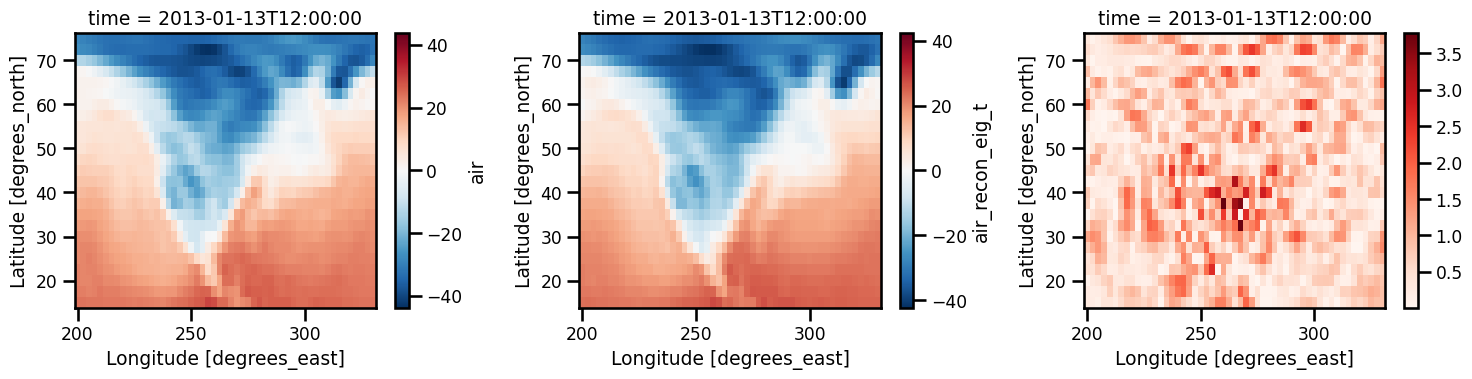

In [9]:
data["air_recon_eig_t"] = (("spatial", "time" ), X_recon)

fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 50

data.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.air_recon_eig_t.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data.air - data.air_recon_eig_t).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

## Covariance Matrix

In [10]:
from sklearn.covariance import shrunk_covariance, ledoit_wolf, empirical_covariance
from sklearn.metrics import pairwise_distances, pairwise_kernels

In [11]:
C_t_ = pairwise_kernels(X.T, metric="rbf")

In [12]:
C_t_

array([[1.00000000e+00, 2.49635789e-02, 3.40647538e-05, ...,
        1.13269859e-18, 1.50067753e-17, 8.24537279e-15],
       [2.49635789e-02, 1.00000000e+00, 2.43902308e-02, ...,
        2.98472890e-15, 1.01408015e-14, 2.63752407e-13],
       [3.40647538e-05, 2.43902308e-02, 1.00000000e+00, ...,
        3.74548429e-14, 1.85066997e-13, 9.78386043e-13],
       ...,
       [1.13269859e-18, 2.98472890e-15, 3.74548429e-14, ...,
        1.00000000e+00, 2.95316019e-02, 3.12312749e-05],
       [1.50067753e-17, 1.01408015e-14, 1.85066997e-13, ...,
        2.95316019e-02, 1.00000000e+00, 9.05261252e-03],
       [8.24537279e-15, 2.63752407e-13, 9.78386043e-13, ...,
        3.12312749e-05, 9.05261252e-03, 1.00000000e+00]])

In [13]:
np.diag(C_t_, k=0)#/(n_time - 1)

array([1., 1., 1., ..., 1., 1., 1.])

In [14]:
np.diag(C_t)

array([166.12920397, 169.33470182, 167.75198338, ..., 176.27947105,
       172.35528469, 172.26732374])

In [15]:
C_t: Float[Array, "Dt Dt"] = (X.T @ X) / (n_time - 1)
C_t_filtered = C_t * C_t_
# C_t_emp = empirical_covariance(X, assume_centered=True)

# C_t_filtered = ledoit_wolf(C_t, assume_centered=True)
# ledoit_wolf(C_t, assume_centered=True, shrinkage=0.99)

In [16]:
C_t

array([[166.12920397, 166.89438917, 164.60578678, ..., 161.82585934,
        160.45021117, 161.83810805],
       [166.89438917, 169.33470182, 167.70050538, ..., 165.21630545,
        163.53179911, 164.22735923],
       [164.60578678, 167.70050538, 167.75198338, ..., 164.99907366,
        163.39956972, 163.7335221 ],
       ...,
       [161.82585934, 165.21630545, 164.99907366, ..., 176.27947105,
        173.51795341, 171.91888044],
       [160.45021117, 163.53179911, 163.39956972, ..., 173.51795341,
        172.35528469, 171.24351901],
       [161.83810805, 164.22735923, 163.7335221 , ..., 171.91888044,
        171.24351901, 172.26732374]])

In [17]:
C_t.min(), C_t.max(), C_t.mean()

(26.173770948955376, 213.62664597464874, 113.5291727115472)

In [18]:
C_t_filtered.min(), C_t_filtered.max(), C_t_filtered.mean()

(0.0, 213.62664597464874, 0.055115619247191064)

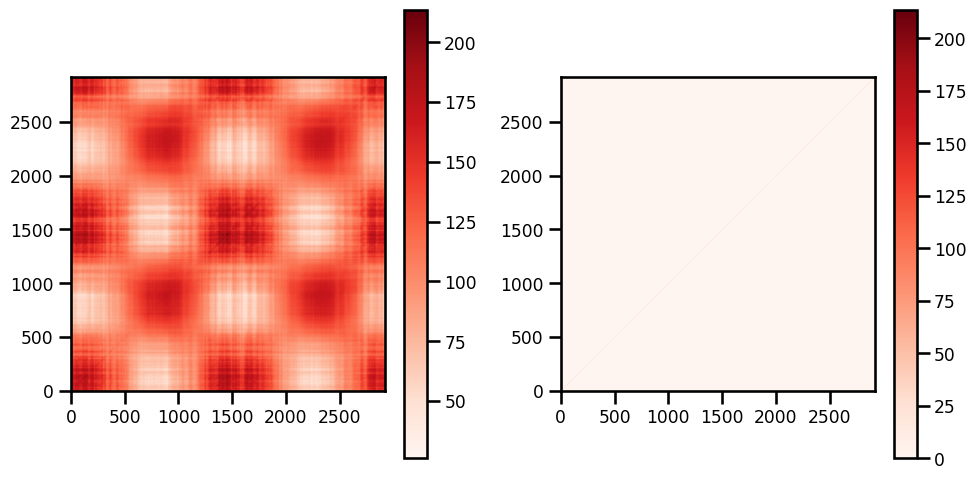

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pbar = ax[0].imshow(C_t.T, origin="lower", cmap="Reds")
plt.colorbar(pbar)

pbar = ax[1].imshow(C_t_filtered.T, origin="lower", cmap="Reds")
plt.colorbar(pbar)

plt.tight_layout()
plt.show()

### Filtered Covariance Matrix

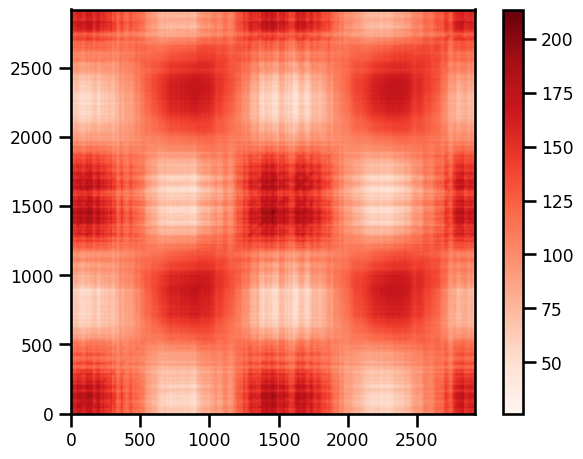

In [20]:
fig, ax = plt.subplots()

pbar = plt.imshow(C_t.T, origin="lower", cmap="Reds")

plt.colorbar(pbar)
plt.tight_layout()

In [21]:
from scipy.ndimage import laplace, sobel

In [27]:
C_t_filter = laplace(C_t, mode="reflect")

In [28]:
C_t.min(), C_t.max(), C_t.mean()

(26.173770948955376, 213.62664597464874, 113.5291727115472)

In [29]:
C_t_filter.min(), C_t_filter.max(), C_t_filter.mean()

(-46.78764898937925, 42.723508256252785, -9.600127035978086e-19)

In [30]:
C_t.min(), C_t.max()

(26.173770948955376, 213.62664597464874)

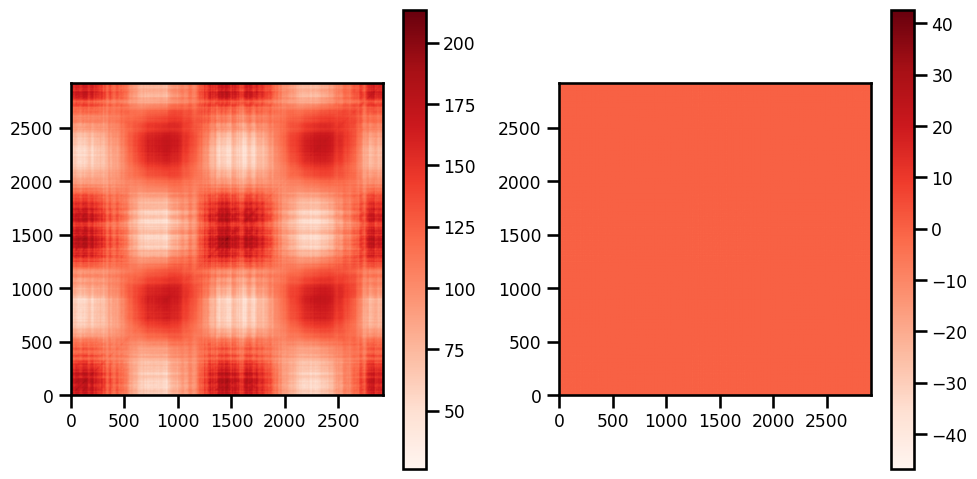

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pbar = ax[0].imshow(C_t.T, origin="lower", cmap="Reds")
plt.colorbar(pbar)

pbar = ax[1].imshow(C_t_filter.T, origin="lower", cmap="Reds")
plt.colorbar(pbar)

plt.tight_layout()
plt.show()

## Adjacency Matrix


In [34]:
from typing import Optional, Union
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray


def time_rescale(
    ds: xr.Dataset,
    freq_dt: int = 1,
    freq_unit: str = "seconds",
    t0: Optional[Union[str, np.datetime64]] = None,
) -> xr.Dataset:
    """Rescales time dimensions of np.datetim64 to an output frequency.

    t' = (t - t_0) / dt

    Args:
        ds (xr.Dataset): the xr.Dataset with a time dimensions
        freq_dt (int): the frequency of the temporal coordinate
        freq_unit (str): the unit for the time frequency parameter
        t0 (datetime64, str): the starting point. Optional. If none, assumes the
            minimum value of the time coordinate

    Returns:
        ds (xr.Dataset): the xr.Dataset with the rescaled time dimensions in the
            freq_unit.
    """

    ds = ds.copy()

    # create time delta
    time_delta = pd.Timedelta(freq_dt, unit=freq_unit)

    if t0 is None:
        t0 = ds["time"].min()

    if isinstance(t0, str):
        t0 = np.datetime64(t0)

    # rescale
    ds["time"] = (ds["time"] - t0) / time_delta

    # change dtype
    ds["time"] = ds["time"].pipe(lambda x: x.astype(np.float32))

    # change attributes
    ds["time"].attrs["units"] = time_delta.unit
    ds["time"].attrs["freq"] = freq_dt
    ds["time"].attrs["t0"] = str(t0.values)

    ds = ds.pint.quantify({"time": freq_unit}).pint.dequantify()

    return ds

In [35]:
time = time_rescale(data.time, freq_dt=1, freq_unit="seconds")

In [36]:
time.time

<xarray.DataArray 'time' (time: 2920)> Size: 12kB
array([0.00000e+00, 2.16000e+04, 4.32000e+04, ..., 6.30072e+07, 6.30288e+07,
       6.30504e+07], dtype=float32)
Coordinates:
  * time     (time) float32 12kB 0.0 2.16e+04 4.32e+04 ... 6.303e+07 6.305e+07
Attributes:
    freq:     1
    t0:       2013-01-01T00:00:00.000000000
    units:    second

In [37]:
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import SpectralEmbedding

In [43]:
T_graph = kneighbors_graph(time.time.values[:, None], n_neighbors=10, mode="connectivity")

In [44]:
T_mat = T_graph.A

In [45]:
C_t_filter = T_mat * C_t

In [46]:
C_t.min()

26.173770948955376

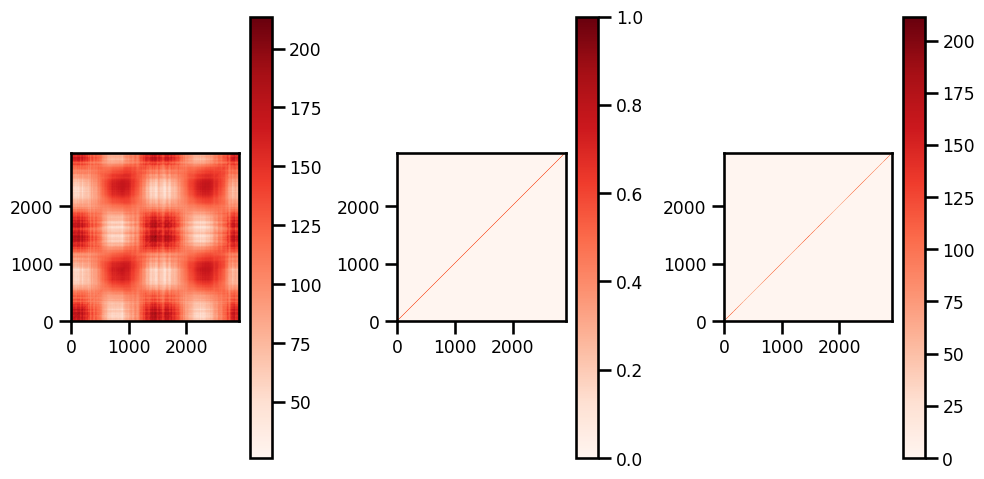

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(10,5))

pbar = ax[0].imshow(C_t, origin="lower", cmap="Reds")
plt.colorbar(pbar)

pbar = ax[1].imshow(T_mat, origin="lower", cmap="Reds")
plt.colorbar(pbar)

pbar = ax[2].imshow(C_t_filter, origin="lower", cmap="Reds")
plt.colorbar(pbar)

plt.tight_layout()
plt.show()

In [92]:
np.diag(T_mat, k=2)

array([1., 1., 1., ..., 1., 1., 1.])

In [67]:
T_graph.todense()

matrix([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

In [68]:
C_t: Float[Array, "Dt Dt"] = (X.T @ X) / (n_time - 1)

In [88]:
C_t_filtered, W = localize_covariance(C_t, loc=10)

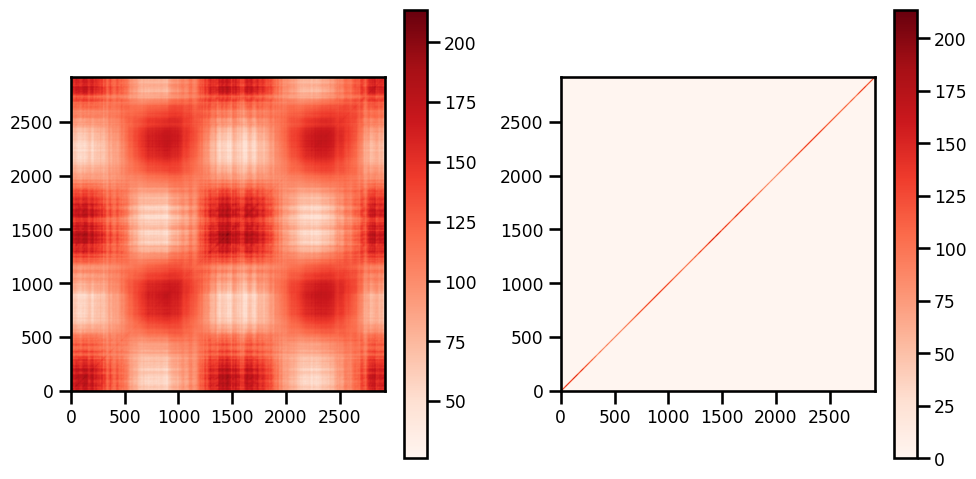

In [89]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pbar = ax[0].imshow(C_t.T, origin="lower", cmap="Reds")
plt.colorbar(pbar)

pbar = ax[1].imshow(C_t_filtered.T, origin="lower", cmap="Reds")
plt.colorbar(pbar)

plt.tight_layout()
plt.show()